In [20]:
# !cp /content/drive/MyDrive/vandecia/denseGroupTPE/database.zip .

In [21]:
# !unzip database.zip

In [22]:
# !pip install hyperopt
# !pip install pymongo
# !pip install nbconvert
# !pip install pydot graphviz
# !pip install visualkeras
# !pip install wandb


In [23]:
# !pip install seaborn

In [24]:
!mkdir results

mkdir: não foi possível criar o diretório “results”: Arquivo existe


In [25]:
import numpy as np
import sklearn as sk
import os
from sklearn.model_selection import train_test_split
import random
import glob
from sklearn.metrics import accuracy_score # deu problema no ultimo treino e agora adicionei isso para que a variavel acc funcione 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.optimizers import SGD, Adam
from sklearn import metrics
from keras import metrics
from keras.models import load_model, Model
from tensorflow.keras.utils import plot_model

from hyperopt import hp
from hyperopt import hp, tpe, Trials, fmin, STATUS_OK
from hyperopt import STATUS_OK, STATUS_FAIL


import json
from bson import json_util

import keras.backend as K
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score

import traceback
import pickle
import uuid

from datetime import datetime

import visualkeras
import wandb
from wandb.integration.keras import WandbCallback  # Esta é a importação correta agora

from sklearn.metrics import confusion_matrix

import seaborn as sns



In [26]:
# os.environ["WANDB_API_KEY"] = "23d0c43f765a434b92508667ed58001b6e7c88d2"

In [27]:
!python -m jupyter nbconvert --to script "*.ipynb"

[NbConvertApp] Converting notebook 9_Otimizando_uma_densenet_from_scratch_[NAS].ipynb to script
[NbConvertApp] Writing 17347 bytes to 9_Otimizando_uma_densenet_from_scratch_[NAS].py
[NbConvertApp] Converting notebook Teste_Dense_Scratch_Geraldo.ipynb to script
[NbConvertApp] Writing 25683 bytes to Teste_Dense_Scratch_Geraldo.py


In [28]:
# import cv2

# def pre_process(im):
#     import cv2
#     import numpy as np

#     # Converte para uint8 se necessário
#     if im.dtype != np.uint8:
#         im = (im * 255).astype(np.uint8) if im.max() <= 1.0 else im.astype(np.uint8)

#     # Garante que tem 3 canais para conversão
#     if im.ndim == 3 and im.shape[2] == 3:
#         im = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)  # RGB → GRAY

#     # Aplica filtro gaussiano e CLAHE
#     im = cv2.GaussianBlur(im, (5, 5), 0)
#     clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(7, 7))
#     im = clahe.apply(im)

#     # Adiciona canal extra para Keras aceitar como imagem grayscale
#     im = np.expand_dims(im, axis=-1)

#     return im.astype(np.float32)



In [29]:
#define o tamanho padrão das imagens que serão passadas na rede, sendo que a mesma aceita imagens maiores que o padrão definido da VGG16 (255x255)
img_width = 200
img_height =  200
batch_size = 8 #batch_size para o treino

#define o batch_size de validação, das imagens de acordo com a memória disponivél na máquina
batch_size_val = 1

#define as épocas
epochs = 1
attention_module = 'Squeeze and Excitation'
# class_weight = {0: 1.48, 1: 4.14, 2:11.49}

RESULTS_DIR = "results/" #pasta para salvar os resultados dos treinamentos

train_data_dir = "database/split1/train"
validation_data_dir = "database/split1/val"
test_data_dir = "database/split1/test"

num_classes_exp = 3


space = {
    'num_blocks': hp.choice('num_blocks', [3]),
    'num_layers_per_block' : hp.choice('num_layers_per_block', [2]),
    'growth_rate': hp.choice('growth_rate', [32]),
    'dropout_rate' : hp.uniform('dropout_rate', 0.2, 0.35),
    'compress_factor' : hp.choice('compress_factor', [0.5]),
    'num_filters' : hp.choice('num_filters', [64])
}


#DataGenerator utilizado para fazer o augmentation on the batch
datagen = ImageDataGenerator(rescale=1./255, # era assim antes de adicionar o clahe
    # featurewise_center=True,
    rotation_range=5,
    width_shift_range=.05,
    height_shift_range=.05,
    # shear_range=0.2,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="constant"
    # preprocessing_function = pre_process,
)
    #  #generator de treino

validgen = ImageDataGenerator(rescale=1./255, 
                            #   featurewise_center=True,
                            # preprocessing_function = pre_process,
                            ) #generator de teste e validação, evita-se realizar alterações nas imagens

#como as imagens apresentam um tamanho maior que o padrão, deve-se fazer uma normalização das mesmas para que sejam aceitas na rede
# datagen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)
# validgen.mean=np.array([103.939, 116.779, 123.68],dtype=np.float32).reshape(1,1,3)


#definindo os geradores para cada pasta
train_gen = datagen.flow_from_directory( #generator para treino
    train_data_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True)

val_gen = validgen.flow_from_directory( #generator para validação
    validation_data_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size_val,
    class_mode="categorical",
    shuffle=True)

test_gen = validgen.flow_from_directory( #generator para teste
    test_data_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=batch_size_val,
    class_mode="categorical",
    shuffle=False)

# Calcule os pesos automaticamente a partir dos dados
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(train_gen.classes), y=train_gen.classes)
class_weight = dict(enumerate(class_weights))

#pega a quantidade de amostras de cada generator
train_samples = len(train_gen.filenames)
validation_samples = len(val_gen.filenames)
test_samples = len(test_gen.filenames)

Found 9697 images belonging to 3 classes.
Found 2425 images belonging to 3 classes.
Found 3031 images belonging to 3 classes.


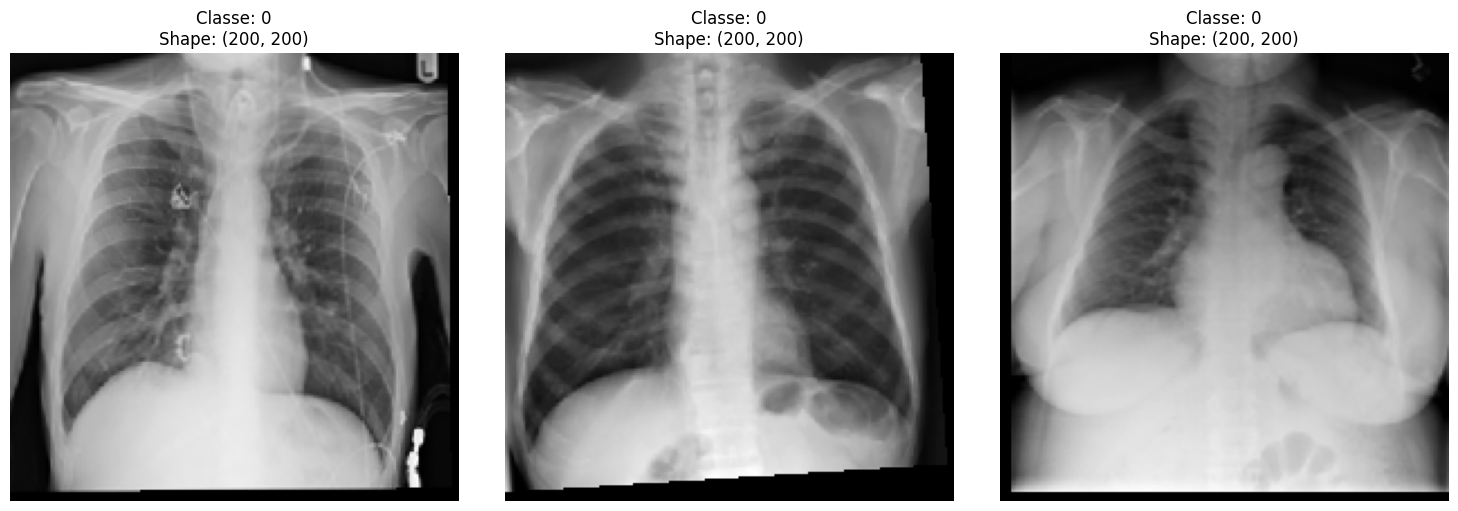

In [30]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_training_images(generator, num_images=3):
    """
    Visualiza imagens do gerador de treino.

    Args:
        generator: Um ImageDataGenerator flow (ex: train_gen)
        num_images: Número de imagens a exibir
    """
    # Obtém um batch de imagens e labels
    images, labels = next(generator)

    # Pega os nomes das classes
    class_names = list(generator.class_indices.keys())

    # Prepara o plot
    plt.figure(figsize=(5 * num_images, 5))

    for i in range(min(num_images, len(images))):
        image = images[i]

        # Desfaz normalização se necessário
        if image.max() <= 1.0:
            image = image * 255.0
        image = np.clip(image, 0, 255).astype(np.uint8)

        # Remove canal extra se for grayscale com shape (H, W, 1)
        if image.ndim == 3 and image.shape[2] == 1:
            image = image.squeeze(-1)

        # Obtém o nome da classe
        label_idx = np.argmax(labels[i])
        label_name = class_names[label_idx]

        # Mostra a imagem
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
        plt.title(f'Classe: {label_name}\nShape: {image.shape}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# Uso: visualize 3 imagens do conjunto de treino
visualize_training_images(train_gen, num_images=3)

In [31]:
tf.keras.backend.clear_session()

def keras_model_memory_usage_in_bytes(model, *, batch_size: int):

    """
    Return the estimated memory usage of a given Keras model in bytes.
    This includes the model weights and layers, but excludes the dataset.

    The model shapes are multipled by the batch size, but the weights are not.

    Args:
        model: A Keras model.
        batch_size: The batch size you intend to run the model with. If you
            have already specified the batch size in the model itself, then
            pass `1` as the argument here.
    Returns:
        An estimate of the Keras model's memory usage in bytes.

    """
    default_dtype = tf.keras.backend.floatx()
    shapes_mem_count = 0
    internal_model_mem_count = 0
    for layer in model.layers:
        if isinstance(layer, tf.keras.Model):
            internal_model_mem_count += keras_model_memory_usage_in_bytes(
                layer, batch_size=batch_size
            )
        single_layer_mem = tf.as_dtype(layer.dtype or default_dtype).size
        out_shape = layer.output_shape
        if isinstance(out_shape, list):
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.trainable_weights]
    )
    non_trainable_count = sum(
        [tf.keras.backend.count_params(p) for p in model.non_trainable_weights]
    )

    total_memory = (
        batch_size * shapes_mem_count
        + internal_model_mem_count
        + trainable_count
        + non_trainable_count
    )
    return total_memory

In [32]:
def save_json_result(model_name, result):
    """Save json to a directory and a filename."""
    result_name = '{}.txt.json'.format(model_name)
    if not os.path.exists(RESULTS_DIR):
        os.makedirs(RESULTS_DIR)
    with open(os.path.join(RESULTS_DIR, result_name), 'w') as f:
        json.dump(
            result, f,
            default=json_util.default, sort_keys=True,
            indent=4, separators=(',', ': ')
        )


In [33]:
from keras import layers
from keras import backend as K
import tensorflow as tf # Importante para tf.reduce_mean e tf.reduce_max

def channel_attention_module(inputs, ratio=8, name=""):
    """
    Módulo de Atenção de Canal (CAM)
    Foca em 'o que' é importante.
    """
    channel_axis = -1 # Geralmente -1 para 'channels_last'
    filters = inputs.shape[channel_axis]

    # Camadas MLP compartilhadas
    shared_mlp_one = layers.Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_mlp_two = layers.Dense(filters, kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')

    # Global Average Pooling
    avg_pool = layers.GlobalAveragePooling2D()(inputs)
    avg_pool = layers.Reshape((1, 1, filters))(avg_pool)
    avg_pool = shared_mlp_one(avg_pool)
    avg_pool = shared_mlp_two(avg_pool)

    # Global Max Pooling
    max_pool = layers.GlobalMaxPooling2D()(inputs)
    max_pool = layers.Reshape((1, 1, filters))(max_pool)
    max_pool = shared_mlp_one(max_pool)
    max_pool = shared_mlp_two(max_pool)

    # Soma e ativação Sigmoid
    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)

    # Multiplicação (broadcast) com a entrada
    return layers.Multiply(name=f"{name}_channel_attention")([inputs, cbam_feature])

def spatial_attention_module(inputs, kernel_size=7, name=""):
    """
    Módulo de Atenção Espacial (SAM)
    Foca em 'onde' é importante.
    """
    channel_axis = -1

    # Average Pooling através dos canais
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=channel_axis, keepdims=True))(inputs)

    # Max Pooling através dos canais
    max_pool = layers.Lambda(lambda x: K.max(x, axis=channel_axis, keepdims=True))(inputs)

    # Concatenação
    concat = layers.Concatenate(axis=channel_axis)([avg_pool, max_pool])

    # Convolução 7x7 e ativação Sigmoid
    cbam_feature = layers.Conv2D(filters=1,
                                 kernel_size=kernel_size,
                                 strides=1,
                                 padding='same',
                                 activation='sigmoid',
                                 kernel_initializer='he_normal',
                                 use_bias=False)(concat)

    # Multiplicação (broadcast) com a entrada
    return layers.Multiply(name=f"{name}_spatial_attention")([inputs, cbam_feature])

def cbam_block(inputs, ratio=8, name=""):
    """
    Módulo de Atenção CBAM Completo.
    Aplica CAM e depois SAM.
    """
    x = channel_attention_module(inputs, ratio=ratio, name=f"{name}_cam")
    x = spatial_attention_module(x, name=f"{name}_sam")
    return x

In [34]:
def se_block(input_tensor, ratio=8, name=None):
    """
    Squeeze-and-Excitation block melhorado para TensorFlow 2.x/Keras.
    
    Args:
        input_tensor: Tensor de entrada (feature map).
        ratio: Fator de redução de canais (default 16 como no paper original).
        name: Prefixo para nomes das camadas (opcional).
    
    Returns:
        Tensor com atenção recalibrada.
    """
    # Obter número de canais/filtros
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    
    # Squeeze: Global Average Pooling
    se = layers.GlobalAveragePooling2D(name=f'{name}_gap' if name else None)(input_tensor)
    se = layers.Reshape(se_shape, name=f'{name}_reshape' if name else None)(se)
    
    # Excitation: Two FC layers with ReLU and Sigmoid
    se = layers.Dense(filters // ratio, 
                     activation='relu',
                     kernel_initializer='he_normal',
                     use_bias=False,
                     name=f'{name}_fc1' if name else None)(se)
    se = layers.Dense(filters, 
                     activation='sigmoid',
                     kernel_initializer='he_normal',
                     use_bias=False,
                     name=f'{name}_fc2' if name else None)(se)
    
    # Scale: Multiply input with excitation weights
    x = layers.Multiply(name=f'{name}_scale' if name else None)([input_tensor, se])
    
    return x

In [35]:
# model = tf.keras.applications.DenseNet121()
# plot_model(model, to_file= "teste_121" + '_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
import numpy as np
import os
from keras.models import Model
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau, EarlyStopping
from keras import layers
from keras.optimizers import SGD, Adam
from sklearn import metrics
from keras import metrics

eps = 1.1e-5
'''
def H( inputs, num_filters , dropout_rate ):
    x = layers.BatchNormalization( epsilon=eps )( inputs )
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D((1, 1))(x)
    x = layers.SeparableConv2D(num_filters, kernel_size=(3, 3), use_bias=False , kernel_initializer='he_normal' )(x)
    x = layers.Dropout(rate=dropout_rate )(x)
    return x
'''
def H( inputs, num_filters , dropout_rate ):
    x = layers.BatchNormalization( epsilon=eps )( inputs )
    x = layers.Activation('relu')(x)

    out_conv = []
    for i in [(1,1),(3,3),(5,5),(0,0)]:
        p = x
        if i == (1,1):
                p = layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p)
                out_conv.append(layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p))
        elif i == (0,0):
                p = layers.MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p))
        else:
                p = layers.Conv2D(num_filters, (1,1), padding="same",activation="relu")(p)
                p = layers.SeparableConv2D(num_filters, i, padding="same",activation="relu")(p)
                out_conv.append(layers.SeparableConv2D(num_filters, i, padding="same",activation="relu")(p))
                
    
    x = layers.concatenate(out_conv, axis = -1)
    x = layers.Dropout(rate=dropout_rate )(x)
    return x

def transition(inputs, num_filters , compression_factor , dropout_rate ):
    # compression_factor is the 'θ'
    x = layers.BatchNormalization( epsilon=eps )(inputs)
    x = layers.Activation('relu')(x)
    num_feature_maps = inputs.shape[1] # The value of 'm'

    x = layers.Conv2D(int(np.floor(num_feature_maps * compression_factor)) ,
                               kernel_size=(1, 1), use_bias=False, padding='same' , kernel_initializer='he_normal')(x)
    x = layers.Dropout(rate=dropout_rate)(x)

    x = layers.AveragePooling2D(pool_size=(2, 2))(x)
    return x

def dense_block( inputs, num_layers, num_filters, growth_rate , dropout_rate,block_idx ):
    for i in range(num_layers): # num_layers is the value of 'l'
        conv_outputs = H(inputs, num_filters , dropout_rate )
        # conv_outputs = se_block(conv_outputs, ratio=8, name=f"se_block{block_idx}_layer{i}")
        inputs = layers.Concatenate()([conv_outputs, inputs])
        num_filters += growth_rate # To increase the number of filters for each layer.
    return inputs, num_filters

def get_model(input_shape,
           num_blocks,
           num_layers_per_block,
           growth_rate,
           dropout_rate,
           compress_factor,
           num_filters,
           num_classes):
    '''
    input_shape = ( 32 , 32 , 3 )
    num_blocks = 3
    num_layers_per_block = 4
    growth_rate = 16
    dropout_rate = 0.4
    compress_factor = 0.5

    num_filters = 16
    '''

    inputs = layers.Input( shape=input_shape )
    x = layers.Conv2D( num_filters , kernel_size=( 3 , 3 ) , padding="same", use_bias=False, kernel_initializer='he_normal')( inputs )
    for i in range( num_blocks ):
        x, num_filters = dense_block(x, num_layers_per_block , num_filters, growth_rate , dropout_rate,block_idx=i)
        x = transition(x, num_filters , compress_factor , dropout_rate )
        
    # x = cbam_block(x, ratio=8, name="cbam_final")    
    x = se_block(x,ratio=8, name="se_final")
    x = layers.GlobalAveragePooling2D()( x )
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dense( num_classes )( x )
    outputs = layers.Activation( 'softmax' )( x )

    model = Model( inputs , outputs )
    
    # #TODO legend_text_spacing_offset deprecated (atualizar depois)
    # visualkeras.layered_view(model, legend=True, to_file='model_architecture.png')  # Salva como imagem
    
    model.compile( loss='categorical_crossentropy' ,optimizer=Adam(),
                    metrics=[ 'accuracy',
                              metrics.Recall(thresholds=0.5, class_id=0,name='r_normal'),
                              metrics.Recall(thresholds=0.5, class_id=1,name='r_covid'),
                              metrics.Recall(thresholds=0.5, class_id=2,name='r_viral')])
    return model

In [37]:
def build_and_train(hype_space):
    print (hype_space)

    #inicializar o wandb para cada experimento
    # wandb.init(
    #     project = "otimizando-uma-dense-from-scratch",
    #     config = hype_space,
    #     reinit=True
    # )

    model_final = get_model(input_shape=(img_width, img_height, 1), # para RGB: 3, para grayscale: 1
            num_blocks = int(hype_space['num_blocks']),
            num_layers_per_block = int(hype_space['num_layers_per_block']),
            growth_rate = int(hype_space['growth_rate']),
            dropout_rate = hype_space['dropout_rate'],
            compress_factor = hype_space['compress_factor'],
            num_filters = hype_space['num_filters'],
            num_classes = num_classes_exp)
# ----------------------------------------------------------------------------
    model_size = keras_model_memory_usage_in_bytes(model = model_final,
                       batch_size = batch_size)
    model_size = model_size/1000000000

    print("Model size: " + str(model_size) )
    if (model_size > 11):
        model_name = "model_" + str(uuid.uuid4())[:5]
        result = {
            'space': hype_space,
            'status': STATUS_FAIL
        }
        # wandb.finish()
        return model_final, model_name, result
    
    weights_file = 'weights_best_etapa1.keras'
    # if os.path.exists(weights_file):
    #     print("Carregando pesos pré-existentes...")
    #     model_final = load_model(weights_file)
    # else:
    #     print("Nenhum peso encontrado. Treinando do zero...")

    # model_final = load_model('weights_best_etapa1.keras')

# ----------------------------------------------------------------------------
    #inicio da fase de treino
    #as imagens são passadas na rede
    early_stopping = EarlyStopping(monitor='val_loss', patience=7,verbose=1, mode='auto')
    checkpoint = ModelCheckpoint('weights_best_etapa1.keras', monitor='val_loss',verbose=1,
                                 save_best_only=True, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
    
    # Troquei wandbcallback() pelo metricsLogger e modelcheckpoint

    model_final.fit(train_gen,
                    epochs=epochs,
                    # steps_per_epoch=int(train_samples/batch_size),
                    validation_data=val_gen,
                    # validation_steps=batch_size_val,
                    class_weight = class_weight,
                    # adicionando wandb aos callbacks
                    verbose=1, callbacks=[early_stopping,checkpoint,reduce_lr,
                                        # WandbMetricsLogger(), # Loga métricas automaticamente
                                        # WandbModelCheckpoint("wandb_model.keras")  # Salva o modelo no wandb .keras
    ])

    preds = model_final.predict(test_gen, test_samples) #realiza o teste de classificação das imagens na rede
    y_pred = np.argmax(preds, axis=1)
    #print(classification_report(test_gen.classes, y_pred))#, target_names=target_names))
    acc = accuracy_score(test_gen.classes, y_pred) #calcula o acurácia era metrics.accuracy_score....
    class_report = classification_report(test_gen.classes, y_pred, output_dict=True)#, target_names=target_names)
    
    # model_pesos = load_model('weights_best_etapa1.hdf5')
    # preds = model_pesos.predict(test_gen, test_samples) #realiza o teste de classificação das imagens na rede
    # y_pred = np.argmax(preds, axis=1)
    # acc_p_1 = accuracy_score(test_gen.classes, y_pred) #calcula o acurácia
    # class_report_p_1 = classification_report(test_gen.classes, y_pred, output_dict=True)#, target_names=target_names)

    # del model_pesos

    # gerando matriz de confusao
    cm = confusion_matrix(test_gen.classes,y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues',
                xticklabels=test_gen.class_indices.keys(),
                yticklabels=test_gen.class_indices.keys()
                )
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão')


    model_name = "model_{}_{}".format(str(acc), str(uuid.uuid4())[:5])
    plot_model(model_final, to_file= RESULTS_DIR + model_name + '_plot.png', show_shapes=True, show_layer_names=True)

    # salvando matriz de confusao
    cm_filename = RESULTS_DIR + model_name + '_confusion_matrix.png'
    plt.savefig(cm_filename)
    plt.close()

    result = {
        'epoch': epochs,
        'batch_treino' : batch_size,
        'batch_teste' : batch_size_val,
        'attention_module': attention_module,
        'loss': 1-acc,
        'acurracy': acc,
        'report': class_report,
        'confusion_matrix': cm.tolist(), #salvando a cm no json
        # 'acurracy_p_1': acc_p_1,
        # 'report_p_1': class_report_p_1,
        'model_name': model_name,
        'space': hype_space,
        'status': STATUS_OK,
        'data_execucao': datetime.now().strftime('%Y-%m-%d %H:%M:%S')  # Formato: Ano-Mês-Dia Hora:Minuto:Segundo
    }

    # # logando as metricas do wandb
    # wandb.log({'final_accuracy': acc,
    #             'final_loss': 1 -acc,
    #             'classification_report':class_report
    #             })

    # print(result)
    # wandb.finish()

    return model_final, model_name, result

def optimize_cnn(hype_space):
    """Build a convolutional neural network and train it."""
    try:
        model, model_name, result = build_and_train(hype_space)

        # Save training results to disks with unique filenames
        save_json_result(model_name, result)

        K.clear_session()
        del model

        return result

    except Exception as err:
        try:
            K.clear_session()
        except:
            pass
        err_str = str(err)
        print(err_str)
        traceback_str = str(traceback.format_exc())
        print(traceback_str)
        return {
            'status': STATUS_FAIL,
            'err': err_str,
            'traceback': traceback_str
        }

    print("\n\n")

def run_a_trial():
    """Run one TPE meta optimisation step and save its results."""
    max_evals = nb_evals = 1

    print("Attempt to resume a past training if it exists:")

    try:
        # https://github.com/hyperopt/hyperopt/issues/267
        trials = pickle.load(open("results.pkl", "rb"))
        print("Found saved Trials! Loadin..")
        max_evals = len(trials.trials) + nb_evals
        print("Rerunning from {} trials to add another one.".format(
            len(trials.trials)))
    except:
        trials = Trials()
        print("Starting from scratch: new trials.")

    best = fmin(
        optimize_cnn,
        space,
        algo=tpe.suggest,
        trials=trials,
        max_evals=max_evals
    )
    pickle.dump(trials, open("results.pkl", "wb"))

    print("\nOPTIMIZATION STEP COMPLETE.\n")

In [38]:
# run_a_trial()

if __name__ == "__main__":
    while True:

        # Optimize a new model with the TPE Algorithm:
        print("OPTIMIZING NEW MODEL:")
        try:
            run_a_trial()
        except Exception as err:
            err_str = str(err)
            print(err_str)
            #traceback_str = str(traceback.format_exc())
            #print(traceback_str)

OPTIMIZING NEW MODEL:
Attempt to resume a past training if it exists:
Found saved Trials! Loadin..
Rerunning from 11 trials to add another one.
{'compress_factor': 0.5, 'dropout_rate': 0.3181386758560805, 'growth_rate': 32, 'num_blocks': 3, 'num_filters': 64, 'num_layers_per_block': 2}
Model size: 13.382549899                               
100%|██████████| 12/12 [00:00<00:00,  1.72trial/s, best loss: 0.6611679313757836]

OPTIMIZATION STEP COMPLETE.

OPTIMIZING NEW MODEL:
Attempt to resume a past training if it exists:
Found saved Trials! Loadin..
Rerunning from 12 trials to add another one.
{'compress_factor': 0.5, 'dropout_rate': 0.20838920057419086, 'growth_rate': 32, 'num_blocks': 3, 'num_filters': 64, 'num_layers_per_block': 2}
Model size: 13.382549899                               
100%|██████████| 13/13 [00:00<00:00,  1.31trial/s, best loss: 0.6611679313757836]

OPTIMIZATION STEP COMPLETE.

OPTIMIZING NEW MODEL:
Attempt to resume a past training if it exists:
Found saved Trials!

KeyboardInterrupt: 